In [38]:
!git clone https://github.com/congnghia0609/ntc-scv.git
!unzip -q ./ntc-scv/data/data_test.zip  -d ./data
!unzip -q ./ntc-scv/data/data_train.zip -d ./data
!rm -rf ./ntc-scv

Cloning into 'ntc-scv'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 39 (delta 0), reused 4 (delta 0), pack-reused 35 (from 1)
Receiving objects: 100% (39/39), 186.94 MiB | 6.59 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [39]:
import os, re, string, time, random
from collections import Counter
import numpy as np
import pandas as pd

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


def set_seed(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.mps.manual_seed(seed)


set_seed(42)

# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device("mps")

print(device)

mps


In [41]:
def load_data_from_path(folder_path):
    examples = []
    for label_name in os.listdir(folder_path):
        full_path = os.path.join(folder_path, label_name)
        for file_name in os.listdir(full_path):
            file_path = os.path.join(full_path, file_name)
            with open(file_path, "r", encoding="utf-8") as f:
                sentence = " ".join(f.readlines())
            label = 1 if label_name == "pos" else 0
            examples.append({"sentence": sentence, "label": label})
    return pd.DataFrame(examples)


folder_paths = {
    "train": "./data/data_train/train",
    "valid": "./data/data_train/test",
    "test": "./data/data_test/test",
}

train_df = load_data_from_path(folder_paths["train"])
test_df = load_data_from_path(folder_paths["test"])
valid_df = load_data_from_path(folder_paths["valid"])


print(train_df.shape, valid_df.shape, test_df.shape)
train_df.head(5)

(30000, 2) (10000, 2) (10000, 2)


,sentence,label
0,Quán đồ_ăn khá ngon . . nhưng phục_vụ không tố...,0
1,"Hôm_nay đi ăn tại quán , món ăn ngon vừa_miệng...",0
2,Qua ́ n cư ̣ c ngon . Tuâ ̀ n na ̀ o mi ̀ nh c...,0
3,"Chán , đồ uống khá nhạt . Với không_gian và ch...",0
4,"Mì ăn ok 👍 🏻 👍 🏻 👍 🏻 nhưng nguội , view rộng ,...",0


In [ ]:
def preprocess_text(text):
    text = re.sub(r"https?://\S+|www\.\S+", " ", text)

    text = re.sub(r"<[^<>]+>", " ", text)

    punct = string.punctuation.replace("_", "")
    replace_chars = punct + string.digits
    for char in replace_chars:
        text = text.replace(char, " ")

    # remove emoji
    emoji_pattern = re.compile(
        "["
        "\U0001f600-\U0001f64f"  # emoticons
        "\U0001f300-\U0001f5ff"  # symbols & pictographs
        "\U0001f680-\U0001f6ff"  # transport & map symbols
        "\U0001f1e0-\U0001f1ff"  # flags (iOS)
        "\U0001f1f2-\U0001f1f4"  # Macau flag
        "\U0001f1e6-\U0001f1ff"  # flags
        "\U0001f600-\U0001f64f"
        "\U00002702-\U000027b0"
        "\U000024c2-\U0001f251"
        "\U0001f926-\U0001f937"
        "\U0001f1f2"
        "\U0001f1f4"
        "\U0001f620"
        "\u200d"
        "\u2640-\u2642"
        "]+",
        flags=re.UNICODE,
    )
    text = emoji_pattern.sub(r" ", text)
    text = " ".join(text.split())
    text = text.lower()

    return text


for df in [train_df, valid_df, test_df]:
    df["text"] = df["sentence"].apply(preprocess_text)

train_df[["text", "label"]].head()

In [ ]:
def tokenize(text: str):
    return text.split()


vocab_size = 10000
specials = ["<pad>", "<unk>"]
pad_token, unk_token = specials

counter = Counter()
for s in train_df["text"].tolist():
    counter.update(tokenize(s))

most_common = counter.most_common(vocab_size - len(specials))
itos = specials + [w for w, _ in most_common]
stoi = {w: i for i, w in enumerate(itos)}

pad_idx = stoi[pad_token]
unk_idx = stoi[unk_token]

print("Vocab size: ", len(itos), "| pad_idx: ", pad_idx, "| unk_idx: ", unk_idx)

In [ ]:
class TextClsDataset(Dataset):
    def __init__(self, texts, labels, stoi, seq_length=100, pad_idx=0, unk_idx=1):
        self.seq_length = seq_length
        self.pad_idx = pad_idx
        self.unk_idx = unk_idx
        self.stoi = stoi

        input_ids = []
        attention_mask = []
        y = []

        for t, lab in zip(texts, labels):
            toks = t.split()
            ids = [self.stoi.get(tok, self.unk_idx) for tok in toks][: self.seq_length]
            mask = [1] * len(ids)

            if len(ids) < self.seq_length:
                pad_len = self.seq_length - len(ids)
                ids = ids + [self.pad_idx] * pad_len
                mask = mask + [0] * pad_len

            input_ids.append(ids)
            attention_mask.append(mask)
            y.append(int(lab))

        self.input_ids = torch.tensor(input_ids, dtype=torch.long)
        self.attention_mask = torch.tensor(attention_mask, dtype=torch.long)
        self.labels = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return self.labels.size(0)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx],
        }

In [ ]:
seq_length = 100
batch_size = 128

train_ds = TextClsDataset(
    train_df["text"].tolist(),
    train_df["label"].tolist(),
    stoi,
    seq_length,
    pad_idx,
    unk_idx,
)
valid_ds = TextClsDataset(
    valid_df["text"].tolist(),
    valid_df["label"].tolist(),
    stoi,
    seq_length,
    pad_idx,
    unk_idx,
)
test_ds = TextClsDataset(
    test_df["text"].tolist(),
    test_df["label"].tolist(),
    stoi,
    seq_length,
    pad_idx,
    unk_idx,
)

pin = True if device.type == "cuda" else False

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=pin)
valid_loader = DataLoader(
    valid_ds, batch_size=batch_size, shuffle=False, pin_memory=pin
)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, pin_memory=pin)

In [ ]:
batch = next(iter(train_loader))
print("Batch shapes: ", {k: v.shape for k, v in batch.items()})

In [ ]:
class PositionalEmbedding(nn.Module):
    def __init__(self, max_len, d_model):
        super().__init__()
        self.pos_emb = nn.Embedding(max_len, d_model)

    def forward(self, input_ids):
        B, L = input_ids.shape
        pos = torch.arange(L, device=input_ids.device).unsqueeze(0).expand(B, L)
        return self.pos_emb(pos)

### Token Embedding & Pos Embedding

In [43]:
set_seed(42)

d_model = 128

input_ids = batch["input_ids"].to(device)
attention_mask = batch["attention_mask"].to(device)
B, L = input_ids.shape

word_emb = nn.Embedding(len(itos), d_model, padding_idx=pad_idx).to(device).eval()
pos_emb = PositionalEmbedding(max_len=L, d_model=d_model).to(device).eval()

with torch.no_grad():
    tok_vec = word_emb(input_ids)
    pos_vec = pos_emb(input_ids)
    X = tok_vec + pos_vec

print("\n=== EMBEDDING ===")
print("input_ids:", input_ids.shape)
print("tok_vec  :", tok_vec.shape)
print("pos_vec  :", pos_vec.shape)
print("X        :", X.shape)
print("Answer:", X[0, 0, 7].detach().cpu())


=== EMBEDDING ===
input_ids: torch.Size([128, 100])
tok_vec  : torch.Size([128, 100, 128])
pos_vec  : torch.Size([128, 100, 128])
X        : torch.Size([128, 100, 128])
Answer: tensor(2.7600)


### Self-Attention

In [42]:
mha = (
    nn.MultiheadAttention(embed_dim=d_model, num_heads=1, batch_first=True)
    .to(device)
    .eval()
)
with torch.no_grad():
    out_sa, attn_sa = mha(
        X,
        X,
        X,
        need_weights=True,
        average_attn_weights=True,  # -> attn_sa: (B, L, L)
    )
print("\n=== SELF-ATTENTION ===")
print("out_sa :", out_sa.shape)  # (B,L,d_model)
print("attn_sa:", attn_sa.shape)  # (B,L,L)

print("\nattn_sa[2, 2, 2]:", attn_sa[2, 2, 2].detach().cpu())



=== SELF-ATTENTION ===
out_sa : torch.Size([128, 100, 128])
attn_sa: torch.Size([128, 100, 100])

attn_sa[2, 2, 2]: tensor(0.0082)


### Masked Self-Attention

In [46]:
key_padding_mask = attention_mask == 0  # (B, L) bool

causal_mask = torch.triu(
    torch.ones(L, L, device=device, dtype=torch.bool), diagonal=1
)  # (L,L)

mha = (
    nn.MultiheadAttention(embed_dim=d_model, num_heads=1, batch_first=True)
    .to(device)
    .eval()
)

with torch.no_grad():
    out_msa, attn_msa = mha(
        X,
        X,
        X,
        key_padding_mask=key_padding_mask,
        attn_mask=causal_mask,
        need_weights=True,
        average_attn_weights=True,  # -> attn_msa: (B,L,L)
    )


print("\n=== MASKED SELF-ATTENTION ===")
print(
    "key_padding_mask:", key_padding_mask.shape, key_padding_mask.dtype, " (True=PAD)"
)
print("causal_mask      :", causal_mask.shape, causal_mask.dtype, " (True=blocked)")
print("out_msa :", out_msa.shape)  # (B,L,d_model)
print("attn_msa:", attn_msa.shape)  # (B,L,L)

print("\nattn_msa[1, 2, 3]:", attn_msa[1, 2, 3].detach().cpu())


=== MASKED SELF-ATTENTION ===
key_padding_mask: torch.Size([128, 100]) torch.bool  (True=PAD)
causal_mask      : torch.Size([100, 100]) torch.bool  (True=blocked)
out_msa : torch.Size([128, 100, 128])
attn_msa: torch.Size([128, 100, 100])

attn_msa[1, 2, 3]: tensor(0.)


### Masked Multi-Head Attention

In [53]:
key_padding_mask = (attention_mask == 0)  # (B, L) bool

causal_mask = torch.triu(
    torch.ones(L, L, device=device, dtype=torch.bool),
    diagonal=1
)  # (L,L)

num_heads = 8
mha = nn.MultiheadAttention(embed_dim=d_model, num_heads=num_heads, batch_first=True).to(device).eval()

with torch.no_grad():
    out_mha, attn_mha = mha(
        X, X, X,
        key_padding_mask=key_padding_mask,
        attn_mask=causal_mask,
        need_weights=True,
        average_attn_weights=False   # (B, heads, L, L)
    )

print("\n=== MASKED MULTI-HEAD ATTENTION ===")
print("key_padding_mask:", key_padding_mask.shape, key_padding_mask.dtype, " (True=PAD)")
print("causal_mask      :", causal_mask.shape, causal_mask.dtype, " (True=blocked)")
print("out_mha :", out_mha.shape)    # (B,L,d_model)
print("attn_mha:", attn_mha.shape)   # (B,heads,L,L)

print("\nattn_mha[4, 4, 4, 4]:", attn_mha[4, 4, 4, 4].detach().cpu())


=== MASKED MULTI-HEAD ATTENTION ===
key_padding_mask: torch.Size([128, 100]) torch.bool  (True=PAD)
causal_mask      : torch.Size([100, 100]) torch.bool  (True=blocked)
out_mha : torch.Size([128, 100, 128])
attn_mha: torch.Size([128, 8, 100, 100])

attn_mha[4, 4, 4, 4]: tensor(0.2247)


In [54]:
# Model Transformer


class TransformerTextClassifier(nn.Module):
    def __init__(
        self,
        vocab_size,
        max_len,
        d_model=200,
        nhead=4,
        dim_ff=128,
        nlayers=2,
        dropout=0.1,
        num_classes=2,
        pad_idx=0,
    ):
        super().__init__()
        self.word_emb = nn.Embedding(vocab_size, d_model, padding_idx=pad_idx)
        self.pos_emb = PositionalEmbedding(max_len, d_model)
        self.drop_in = nn.Dropout(dropout)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_ff,
            dropout=dropout,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=nlayers)

        self.fc1 = nn.Linear(d_model, 64)
        self.act = nn.ReLU()
        self.drop = nn.Dropout(dropout)
        self.fc2 = nn.Linear(64, num_classes)

    def masked_mean_pool(self, x, attention_mask):
        # x: (B,L,D); attention_mask: (B,L) 1 token, 0 pad
        m = attention_mask.unsqueeze(-1).float()
        x = x * m
        denom = m.sum(dim=1).clamp(min=1.0)
        return x.sum(dim=1) / denom

    def forward(self, input_ids, attention_mask):
        x = self.word_emb(input_ids) + self.pos_emb(input_ids)
        x = self.drop_in(x)

        key_padding_mask = attention_mask.eq(0)  # True at PAD
        x = self.encoder(x, src_key_padding_mask=key_padding_mask)

        pooled = self.masked_mean_pool(x, attention_mask)
        out = self.fc2(self.drop(self.act(self.fc1(pooled))))
        return out


model = TransformerTextClassifier(
    vocab_size=len(itos),
    max_len=seq_length,
    d_model=200,
    nhead=4,
    dim_ff=128,
    nlayers=2,
    dropout=0.1,
    num_classes=2,
    pad_idx=pad_idx,
).to(device)

print(model.__class__.__name__)

TransformerTextClassifier


In [57]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)


def train_one_epoch(model, loader):
    model.train()
    total_correct, total_count, total_loss = 0, 0, 0.0

    for batch in loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (logits.argmax(1) == labels).sum().item()
        total_count += labels.size(0)

    return total_correct / total_count, total_loss / max(len(loader), 1)


@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_correct, total_count, total_loss = 0, 0, 0.0

    for batch in loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)

        total_loss += loss.item()
        total_correct += (logits.argmax(1) == labels).sum().item()
        total_count += labels.size(0)

    return total_correct / total_count, total_loss / max(len(loader), 1)


In [58]:
num_epochs = 20

train_accs, train_losses = [], []
val_accs, val_losses = [], []

for epoch in range(1, num_epochs + 1):
    t0 = time.time()

    tr_acc, tr_loss = train_one_epoch(model, train_loader)
    va_acc, va_loss = evaluate(model, valid_loader)

    train_accs.append(tr_acc)
    train_losses.append(tr_loss)
    val_accs.append(va_acc)
    val_losses.append(va_loss)

    dt = time.time() - t0
    print(
        f"Epoch {epoch:02d}/{num_epochs} | Time {dt:5.1f}s | "
        f"Train Acc {tr_acc:.4f} Loss {tr_loss:.4f} | "
        f"Val Acc {va_acc:.4f} Loss {va_loss:.4f}"
    )


/Users/vychan/Coding/AIO2025/Code/aio2025_study/venv_tf/lib/python3.10/site-packages/torch/nn/modules/transformer.py:467: UserWarning: The operator 'aten::_nested_tensor_from_mask_left_aligned' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:15.)
  ) and not torch._nested_tensor_from_mask_left_aligned(


Epoch 01/20 | Time  10.0s | Train Acc 0.6650 Loss 0.6159 | Val Acc 0.7605 Loss 0.5112
Epoch 02/20 | Time   9.5s | Train Acc 0.7757 Loss 0.4843 | Val Acc 0.7854 Loss 0.4692
Epoch 03/20 | Time   9.5s | Train Acc 0.7952 Loss 0.4512 | Val Acc 0.8016 Loss 0.4433
Epoch 04/20 | Time   9.5s | Train Acc 0.8103 Loss 0.4266 | Val Acc 0.8059 Loss 0.4273
Epoch 05/20 | Time   9.5s | Train Acc 0.8174 Loss 0.4094 | Val Acc 0.8113 Loss 0.4175
Epoch 06/20 | Time   9.5s | Train Acc 0.8263 Loss 0.3949 | Val Acc 0.8208 Loss 0.4043
Epoch 07/20 | Time   9.5s | Train Acc 0.8332 Loss 0.3802 | Val Acc 0.8265 Loss 0.3938
Epoch 08/20 | Time   9.7s | Train Acc 0.8427 Loss 0.3650 | Val Acc 0.8318 Loss 0.3864
Epoch 09/20 | Time   9.6s | Train Acc 0.8467 Loss 0.3559 | Val Acc 0.8337 Loss 0.3809
Epoch 10/20 | Time   9.6s | Train Acc 0.8499 Loss 0.3466 | Val Acc 0.8331 Loss 0.3789
Epoch 11/20 | Time   9.7s | Train Acc 0.8570 Loss 0.3363 | Val Acc 0.8398 Loss 0.3730
Epoch 12/20 | Time   9.7s | Train Acc 0.8575 Loss 0.33

In [59]:
test_acc, test_loss = evaluate(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

Test Accuracy: 0.8458 | Test Loss: 0.3748


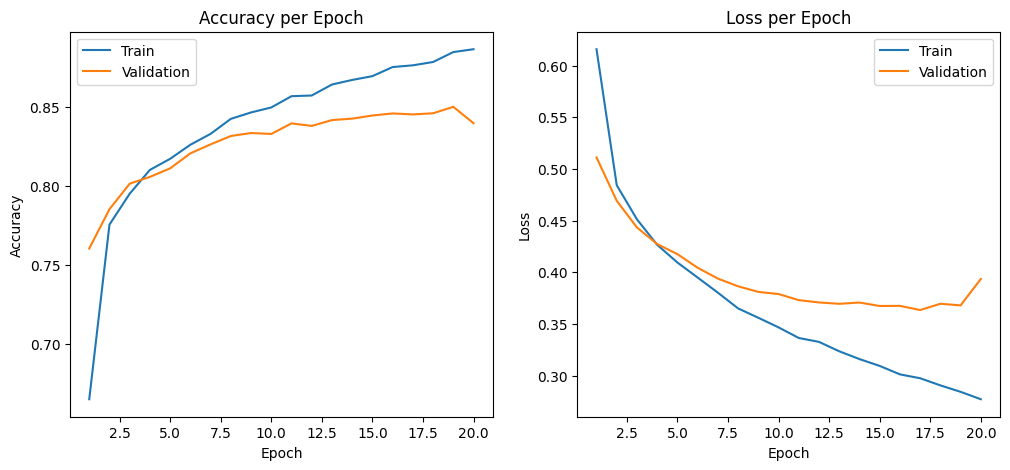

In [60]:
def plot_metrics(train_accs, val_accs, train_losses, val_losses):
    epochs = range(1, len(train_accs) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_accs, label="Train")
    plt.plot(epochs, val_accs, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy per Epoch")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_losses, label="Train")
    plt.plot(epochs, val_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss per Epoch")
    plt.legend()

    plt.show()


plot_metrics(train_accs, val_accs, train_losses, val_losses)